# River Elevation and Cross-Section

In [1]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point

import py3dep
import pygeoogc.utils as ogc_utils
import pynhd
from pynhd import NLDI, WaterData

We can retrieve elevation profile for tributaries of a given USGS station ID using `PyNHD` and `Py3DEP`. For this purpose, we get the elevation data for points along the tributaries' flowlines every one kilometer. Note that since the distance is in meters we reproject the geospatial data into ESRI:102003.

In [2]:
crs_proj = 5070
station_id = "01031500"
distance = 1000  # in meters

First, let's get the basin geometry and tributaries for the station.

In [3]:
nldi = NLDI()

basin = nldi.get_basins(station_id)
flw = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="flowlines",
    distance=100,
)
flw = flw.set_index("nhdplus_comid").to_crs(crs_proj)

First, we need to get the main river's flowlines.

Now, we can compute the number of points along each river segment based on the target 1-km distance. Note that since we want to sample the data from a DEM in EPSG:4326 wen need to reproject the sample points from EPSG:102003 to EPSG:4326. We use `pygeoogc.utils.match_crs` to do so.

In [4]:
flw["n_points"] = np.ceil(flw.length / distance).astype("int")
flw_points = [
    (
        n,
        list(
            zip(
                *ogc_utils.match_crs(
                    [
                        (p[0][0], p[1][0])
                        for p in (
                            line.interpolate(x, normalized=True).xy
                            for x in np.linspace(0, 1, pts, endpoint=False)
                        )
                    ],
                    crs_proj,
                    4326,
                )
            )
        ),
    )
    for n, line, pts in flw.itertuples(name=None)
]

We use `Py3DEP` to get elevation data for these points. We can either use `py3dep.elevation_bycoords` to get elevations directly from 3DEP's static DEM VRTs at 10-m resolution or use `py3dep.get_dem` to get the elevation data for the entire basin and then sample it for the target locations.

Using `py3dep.elevation_bycoords` is simpler but in this case we want to apply hydrologic conditioning to the DEM. For this purpose, we use `py3dep.get_dem` to get the elevation data for the entire basin and then sample it for the target locations.Here's the code to get the elevation data using `py3dep.elevation_bycoords`:

```python
flw_elevation = [(n, py3dep.elevation_bycoords(pts, CRS)) for n, pts in flw_points]
```

Let's continue with using `py3dep.get_dem`.

In [5]:
dem = py3dep.get_dem(basin.geometry[0].bounds, resolution=10)

Py3DEP uses [pyflwdir](https://deltares.github.io/pyflwdir) for filling depressions. It's an optional dependency and you need to install it separately.

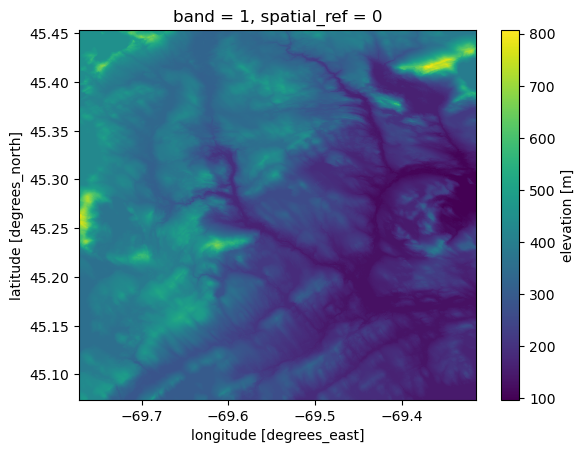

In [6]:
dem = py3dep.fill_depressions(dem)
dem.plot.imshow()

In [7]:
flw_elevation = [
    (n, dem.interp(x=("z", list(pts[0])), y=("z", list(pts[1]))).values) for n, pts in flw_points
]

Now that we have both the coordinates and their elevation data for the points, we can create a new dataframe and plot the results.

In [8]:
points = pd.DataFrame(((n, list(zip(*pts))) for n, pts in flw_points)).set_index(0)[1].explode()
points = pd.DataFrame([(n, Point(p)) for n, p in points.items()])
points = points.rename(columns={0: "comid", 1: "geometry"}).set_index("comid")
points = gpd.GeoDataFrame(points, crs=4326).to_crs(crs_proj)
elevations = pd.DataFrame(flw_elevation).rename(columns={0: "comid", 1: "elevation"})
elevations = elevations.set_index("comid")["elevation"].explode().astype("float")
points["elevation"] = elevations

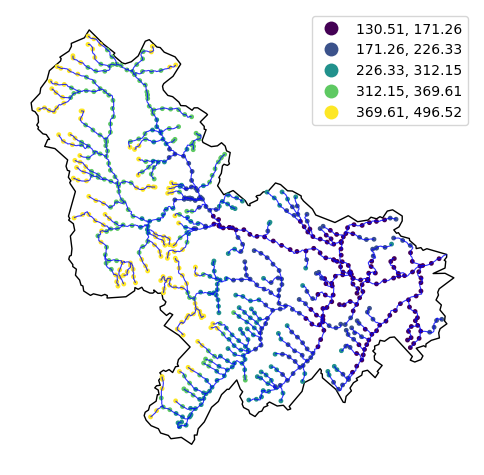

In [9]:
ax = basin.to_crs(crs_proj).plot(figsize=(6, 6), facecolor="none", edgecolor="black")
points.plot(ax=ax, column="elevation", markersize=6, legend=True, scheme="quantiles")
flw.plot(ax=ax, color="b", linewidth=0.8, alpha=0.8)
ax.set_axis_off()

Let's extract corss-section profiles along the main river of the basin. We get cross-section profiles at every 3 km along the main river and within a buffer distance of 2 km.

In [10]:
distance = 3000  # in meters
width = 2000  # in meters
half_width = width * 0.5

First, we need to get the main river's flowlines.

In [11]:
main = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=100,
)
main = main.set_index("nhdplus_comid").to_crs(crs_proj)

In [12]:
nhd = WaterData("nhdflowline_network")
main_nhd = nhd.byid("comid", main.index.to_list())
main_nhd = pynhd.prepare_nhdplus(main_nhd, 0, 0, 0, purge_non_dendritic=True).to_crs(crs_proj)
cs = pynhd.network_xsection(main_nhd, distance, width)

Let's plot the obtained cross-section lines.

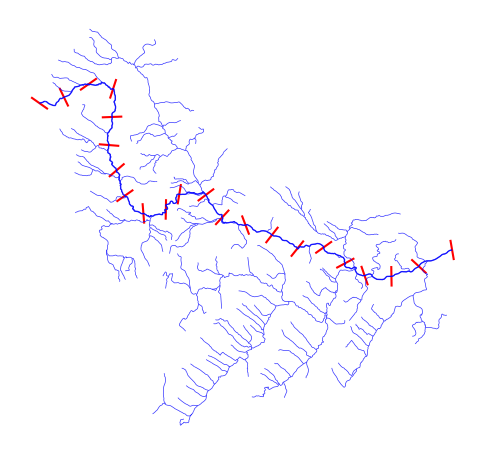

In [13]:
ax = cs.plot(color="r", figsize=(6, 6))
main.plot(ax=ax, color="b", linewidth=1, alpha=0.8)
flw.plot(ax=ax, color="b", linewidth=0.5, alpha=0.8)
ax.set_axis_off()
ax.figure.savefig(Path("_static", "cross_section.png"), dpi=300, bbox_inches="tight", facecolor="w")

Using the obtained cross-section lines, we can compute the cross-section profiles every 500 meters along the cross-section lines following the same procedure as before.

In [14]:
distance = 100  # in meters
cs["n_points"] = np.ceil(cs.length / distance).astype("int")
cs_points = [
    (
        n,
        list(
            zip(
                *ogc_utils.match_crs(
                    [
                        (p[0][0], p[1][0])
                        for p in (
                            line.interpolate(x, normalized=True).xy
                            for x in np.linspace(0, 1, pts, endpoint=False)
                        )
                    ],
                    crs_proj,
                    4326,
                )
            )
        ),
    )
    for n, line, pts in cs.itertuples(name=None)
]
cs_elevation = [
    (n, dem.interp(x=("z", list(pts[0])), y=("z", list(pts[1]))).values) for n, pts in cs_points
]

In [15]:
points = pd.DataFrame(((n, list(zip(*pts))) for n, pts in cs_points)).set_index(0)[1].explode()
points = pd.DataFrame([(n, Point(p)) for n, p in points.items()])
points = points.rename(columns={0: "comid", 1: "geometry"}).set_index("comid")
points = gpd.GeoDataFrame(points, crs=4326).to_crs(crs_proj)
elevations = pd.DataFrame(cs_elevation).rename(columns={0: "comid", 1: "elevation"})
elevations = elevations.set_index("comid")["elevation"].explode().astype("float")
points["elevation"] = elevations

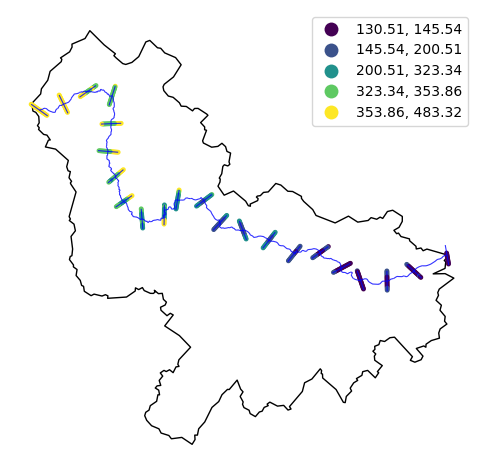

In [16]:
ax = basin.to_crs(crs_proj).plot(figsize=(6, 6), facecolor="none", edgecolor="black")
main.plot(ax=ax, color="b", linewidth=0.8, alpha=0.8)
points.plot(ax=ax, column="elevation", markersize=6, legend=True, scheme="quantiles")
cs.plot(ax=ax, color="b", linewidth=0.8, alpha=0.8)
ax.set_axis_off()